## Options
#### Color Preservation:
- No preservation (this will allow the style image to override the content image's color)
- Lumiance synthesis (this will maintain the content image's color with a focus on maintaining accurate colors)
- Color synthesis (this will maintain the content image's color with a focus on maintaining accurate texture from the style image)

#### Style weighting
- Adjust the ratio to determine how heavily the algorithm should weigh maintaining the content of the content image vs incorporating more of the style image

#### Masked style transfer
- Choose between applying style to background, foreground, or both

#### Automatic upsampling
- Automatically apply upsampling algorithm after generated the new image. Useful if you're going to print or display at a higher resolution anyways, but may reduce quality

In [1]:
# Imports
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG19, vgg19
import numpy as np
import matplotlib.pyplot as plt
import util
import IPython.display as display
import PIL.Image

In [2]:
### Settings
# Color preservation
color_preserve = False

# Style weighting
style_weight = 8e-5

# Masking
mask = None

# Upsampling
upsample = False

# Starting Image (content, style, random)
starter_image = 'random'

# Image paths
style_image_path = './Style images/shipwreck.jpg'
content_image_path = './Content images/tuebingen resized.jpg'

# RGB Images
b, g, r = cv2.split(cv2.imread(style_image_path))
style_image = cv2.merge((r, g, b))
b, g, r = cv2.split(cv2.imread(content_image_path))
content_image = cv2.merge((r, g, b))

# Display selected images
window_name = 'test_view'

In [3]:
# Preprocessing
if color_preserve:
    # Adjust luminance of style image to better match content before transferring style
    style_image = util.transfer_luminance(content_image, style_image)
    
# Adjust size of style image to match that of content image so they can both pass through the same network
content_image_dimensions = content_image.shape
height, width, channels = content_image_dimensions
style_image = np.array(tf.image.resize(style_image, content_image_dimensions[:2]), dtype=np.uint8)

In [4]:
#r, g, b = cv2.split(content_image)
#cv2.imshow("content", cv2.merge((b, g, r)))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#r, g, b = cv2.split(style_image)
#cv2.imshow('style', cv2.merge((b, g, r)))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [5]:
# Reference: https://arxiv.org/pdf/1508.06576.pdf (pages 9 and 10)
# Which layers are used for style loss
s_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Which layers are used for content loss (try with 'conv5_2')
c_layers = ['block4_conv2']

### Loss functions
def content_loss(content_features_dict, generated):
    generated = generated['content']
    l = tf.add_n([0.5*tf.reduce_sum(tf.square(content_features_dict[name] - generated[name]))]
                      for name in content_features_dict.keys())
    l = l / num_content_layers
    return tf.cast(l, tf.float64)

def style_loss(style_features_dict, generated):
    generated = generated['style']
    layer_losses = []
    for layer in style_features_dict.keys():
        dividend = tf.cast(tf.reduce_sum(tf.square(tf.subtract(style_features_dict[layer], generated[layer]))), tf.float64)
        divisor = 4*(tf.cast(tf.math.square(generated[layer].shape[1]), tf.float64)**2)
        layer_losses.append(dividend / divisor)
    l = tf.add_n(layer_losses)
    l = l / num_style_layers
    return l

def total_loss(content_features, style_features, generated):
    l = content_weight*content_loss(content_features, generated) + style_weight*style_loss(style_features, generated)
    return l

In [12]:
# Network definition
model = VGG19(include_top = False, pooling= 'max', weights = 'imagenet', input_shape = content_image_dimensions)
class NSTModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, model):
    super(NSTModel, self).__init__()
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    outputs = [model.get_layer(name).output for name in s_layers+c_layers]
    model = tf.keras.Model([model.input], outputs)
    self.model = model
    self.model.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    #inputs = inputs*255.0
    #preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    preprocessed_input = tf.reshape(inputs, (1, height, width, channels))
    outputs = self.model(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [util.gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [19]:
extractor = NSTModel(s_layers, c_layers, model)

white_noise = np.random.uniform(size=content_image_dimensions)
style_image = util.scale_image(tf.Variable(tf.cast(tf.convert_to_tensor(style_image), dtype=tf.float32), trainable=True))
content_image = util.scale_image(tf.Variable(tf.cast(tf.convert_to_tensor(content_image), dtype=tf.float32), trainable=True))
image = tf.Variable(tf.cast(tf.convert_to_tensor(content_image), dtype=tf.float32), trainable=True)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.03,
    decay_steps=1500,
    decay_rate=0.95)
opt = tf.optimizers.Adam(learning_rate=lr_schedule, epsilon=0.1)

ratio = 1e-3 # Equal to alpha/beta (content/style) in paper - larger number emphasizes content more
content_weight = 1
style_weight = content_weight / ratio
total_variation_weight = 8e-4
num_style_layers = len(s_layers)
num_content_layers = len(c_layers)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = total_loss(content_targets, style_targets, outputs)
    #loss += total_variation_weight*tf.cast(tf.image.total_variation(image), tf.float64)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(util.scale_image(image))
    return(loss)

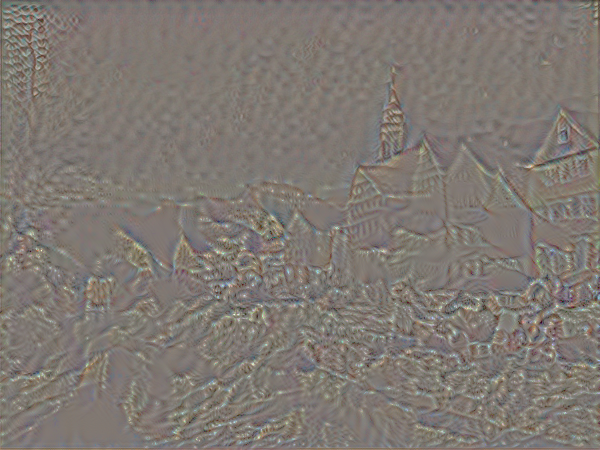

Train step: 174   Total Loss 106054656   Change in Loss -1114611


KeyboardInterrupt: 

In [20]:
import time
start = time.time()

epochs = 200
steps_per_epoch = 1
step_list = np.linspace(start=steps_per_epoch, stop=steps_per_epoch*epochs, num=epochs, dtype=np.int32)
loss_list = []

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        l = train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(PIL.Image.fromarray(np.array(image*255, dtype=np.uint8)))
    loss_list.append(l)
    loss_diff = l - loss_list[len(loss_list)-2]
    print("Train step: %d   Total Loss %d   Change in Loss %d"%(step, l, loss_diff))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [11]:
print("Content loss: %f" % content_loss(content_targets, extractor(image)), 
      "\nStyle Loss: %f" % style_loss(style_targets, extractor(image)),
      "\nTotal Variation: %f" % (tf.image.total_variation(image)*total_variation_weight))

Content loss: 737875197952.000000 
Style Loss: 1007884088985.365845 
Total Variation: 12011.797852


In [ ]:
25557402

In [11]:
#r, g, b = cv2.split(np.array(image*255, dtype=np.uint8))
#bgr_stylized = cv2.merge((b, g, r))
#cv2.imwrite('stylized.png', bgr_stylized)

True